In [1]:
!pip install evaluate wandb transformers datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [3]:
import os
import zipfile
from google.colab import drive
from datasets import load_dataset

# Mount Google Drive
drive.mount('/content/drive')

# Path to your dataset ZIP file
zip_file_path = "/content/drive/MyDrive/Home_tasks_DL/Home_task_9/DataSetForHomeTask9B.zip"

# Path where the dataset will be extracted
extract_path = "/content/DataSetForHomeTask9B"

# Unzipping the dataset
if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
        print(f"Dataset extracted to {extract_path}")

# Load the dataset
dataset = load_dataset("imagefolder", data_dir=extract_path)

# Display dataset details
print(dataset)

Mounted at /content/drive
Dataset extracted to /content/DataSetForHomeTask9B


Resolving data files:   0%|          | 0/2526 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/200 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/200 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 2526
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 200
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 200
    })
})


In [6]:
# Get the class labels (assumed to be folder names in the dataset directory)
labels = dataset["train"].features["label"].names
print(f"Labels: {labels}")  # Should output: ['autistic', 'non-autistic']


Labels: ['autistic', 'non_autistic']


In [7]:
from transformers import ViTForImageClassification, ViTImageProcessor

# Model name
model_name = "google/vit-base-patch16-224"

# Load the image processor for preprocessing
image_processor = ViTImageProcessor.from_pretrained(model_name)

# Load the ViT model, configured for your 2-class dataset
model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=len(labels),  # Number of labels (2 in this case)
    id2label={str(i): label for i, label in enumerate(labels)},
    label2id={label: str(i) for i, label in enumerate(labels)},
    ignore_mismatched_sizes=True,  # Handles size mismatch gracefully
)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


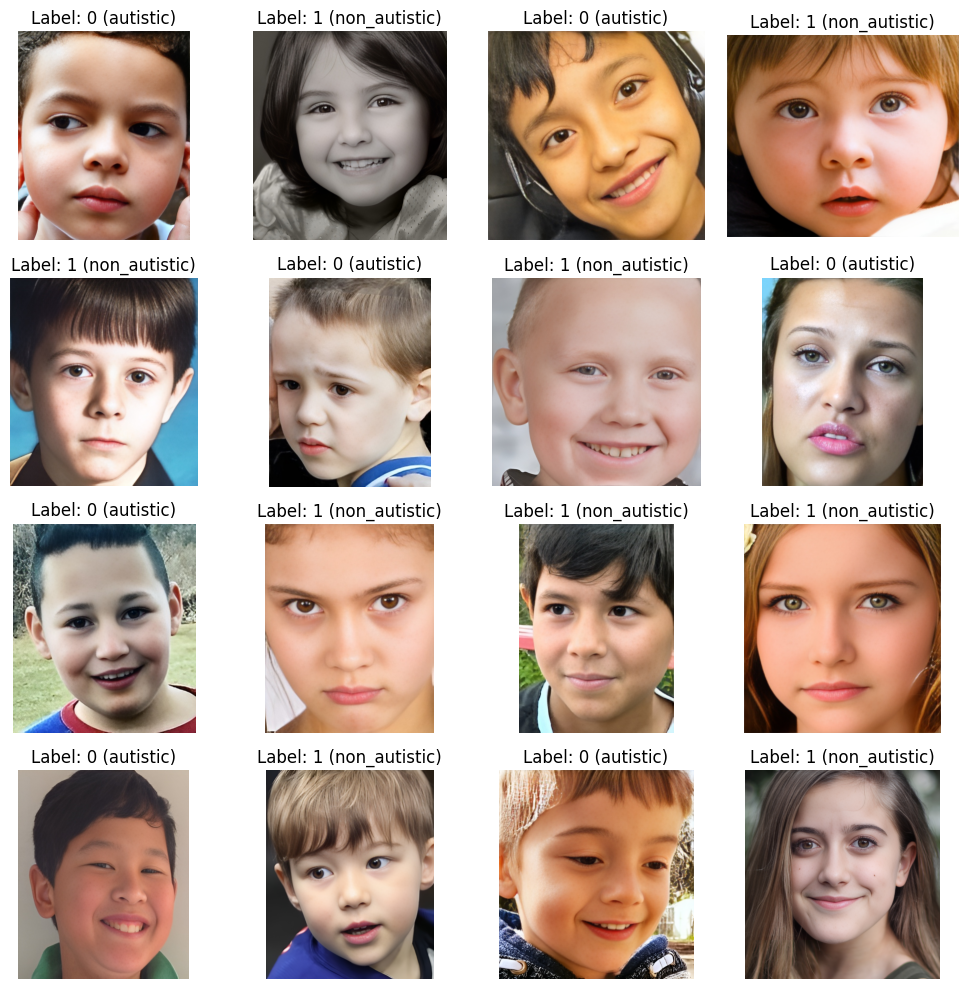

In [8]:
import matplotlib.pyplot as plt
import random
def show_image_grid(dataset, split, grid_size=(4, 4)):
    indices = random.sample(range(len(dataset[split])), grid_size[0] * grid_size[1])
    images = [dataset[split][i]["image"] for i in indices]
    labels = [dataset[split][i]["label"] for i in indices]

    fig, axes = plt.subplots(nrows=grid_size[0], ncols=grid_size[1], figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
        ax.axis("off")
        ax.set_title(f"Label: {labels[i]} ({dataset[split].features['label'].int2str(labels[i])})")
    plt.tight_layout()
    plt.show()

# Visualize the training dataset
show_image_grid(dataset, "train")

In [10]:
def transform(examples):
    # Convert images to RGB format and preprocess using the image processor
    inputs = image_processor([img.convert("RGB") for img in examples["image"]], return_tensors="pt")
    inputs["labels"] = examples["label"]  # Include the labels
    return inputs

# Apply the transformation to your dataset
dataset = dataset.with_transform(transform)

In [12]:
from evaluate import load
import numpy as np
import torch

def collate_fn(batch):
  return {
      "pixel_values": torch.stack([x["pixel_values"] for x in batch]),
      "labels": torch.tensor([x["labels"] for x in batch]),
  }

# load the accuracy and f1 metrics from the evaluate module
accuracy = load("accuracy")
f1 = load("f1")


def compute_metrics(eval_pred):
  # compute the accuracy and f1 scores & return them
  accuracy_score = accuracy.compute(predictions=np.argmax(eval_pred.predictions, axis=1), references=eval_pred.label_ids)
  f1_score = f1.compute(predictions=np.argmax(eval_pred.predictions, axis=1), references=eval_pred.label_ids, average="macro")
  return {**accuracy_score, **f1_score}

In [16]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./vit-base-autism",  # Directory for saving model checkpoints
    per_device_train_batch_size=16,
    evaluation_strategy="steps",
    learning_rate=5e-5,
    num_train_epochs=1,
    save_steps=500,
    eval_steps=500,
    logging_steps=500,
    save_total_limit=2,
    remove_unused_columns=False,
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,                         # Model to train
    args=training_args,                  # Training arguments
    data_collator=collate_fn,            # Batch collation
    compute_metrics=compute_metrics,     # Accuracy and F1 metrics
    train_dataset=dataset["train"],      # Training dataset
    eval_dataset=dataset['validation'],        # Validation dataset
    tokenizer=image_processor,           # Preprocessor
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-16-51490dd08ef2>:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [18]:
# Train the model
trainer.train()

Step,Training Loss,Validation Loss


TrainOutput(global_step=158, training_loss=0.4241672950454905, metrics={'train_runtime': 5356.8192, 'train_samples_per_second': 0.472, 'train_steps_per_second': 0.029, 'total_flos': 1.9698463760029286e+17, 'train_loss': 0.4241672950454905, 'epoch': 1.0})

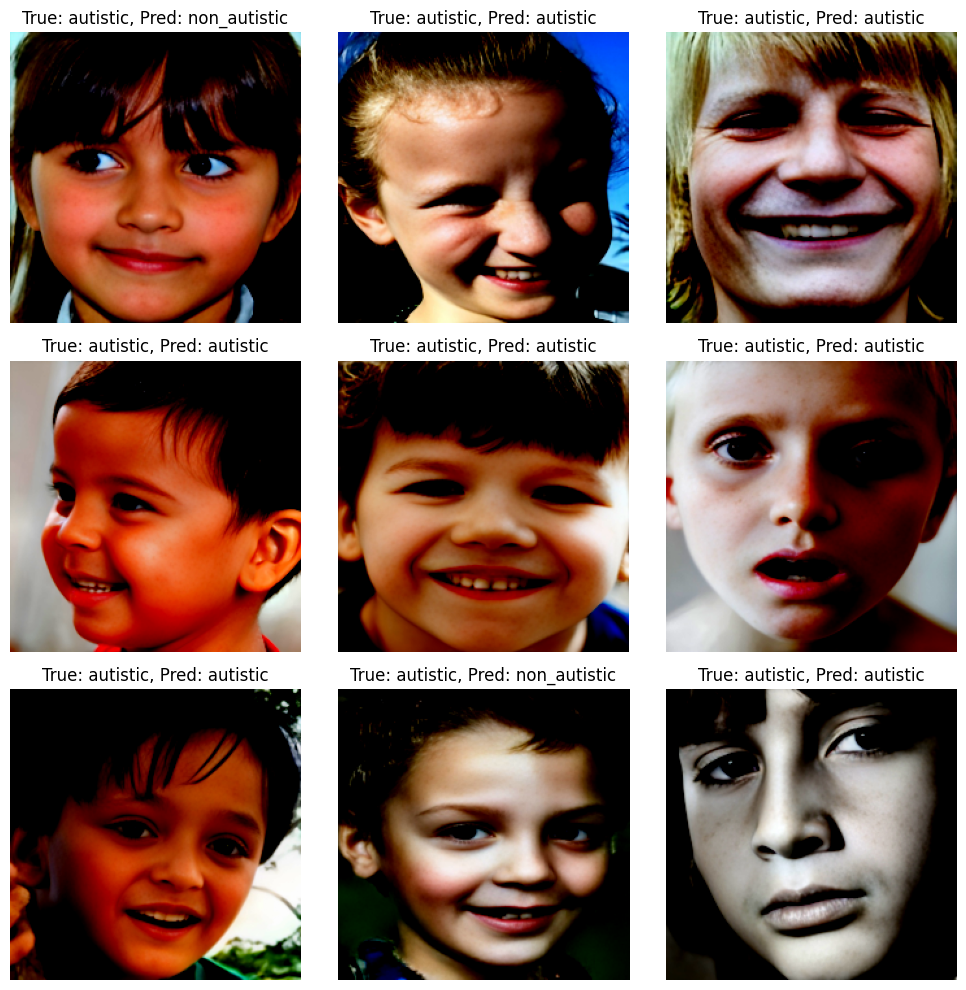

In [19]:
from torch.utils.data import DataLoader
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
# Create a DataLoader for test data
test_loader = DataLoader(dataset["test"], batch_size=9, shuffle=False, collate_fn=collate_fn)

# Get a batch of test data
batch = next(iter(test_loader))

# Perform inference
output = model(batch["pixel_values"].to(device))
pred_label_indices = output.logits.softmax(dim=1).argmax(dim=1)
pred_labels = [model.config.id2label[str(idx.item())] for idx in pred_label_indices]
true_labels = [model.config.id2label[str(idx.item())] for idx in batch["labels"]]

# Visualize predictions
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    image = batch["pixel_values"][i].cpu().numpy().transpose((1, 2, 0))
    ax.imshow(image)
    ax.axis("off")
    ax.set_title(f"True: {true_labels[i]}, Pred: {pred_labels[i]}")
plt.tight_layout()
plt.show()


In [20]:
# Evaluate the model
results = trainer.evaluate(dataset["test"])
print("Evaluation Results:", results)

Evaluation Results: {'eval_loss': 0.27619174122810364, 'eval_accuracy': 0.89, 'eval_f1': 0.89, 'eval_runtime': 144.0675, 'eval_samples_per_second': 1.388, 'eval_steps_per_second': 0.174, 'epoch': 1.0}


In [21]:
# Save the trained model to Google Drive
model_save_path = "/content/drive/MyDrive/Task9b"  # Specify the desired save location
os.makedirs(model_save_path, exist_ok=True)  # Create the directory if it doesn't exist
trainer.save_model(model_save_path)
print(f"Model saved to: {model_save_path}")

Model saved to: /content/drive/MyDrive/Task9b


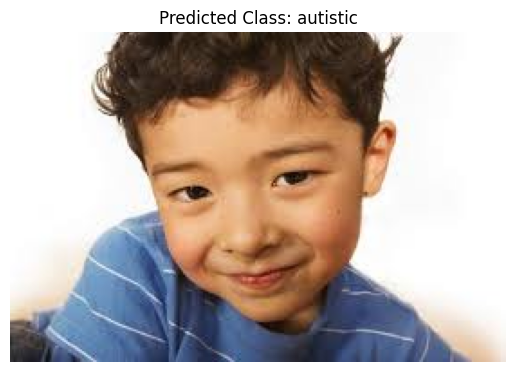

The predicted class for the image is: autistic


In [30]:

import torch
from PIL import Image
import matplotlib.pyplot as plt

# Assuming 'model', 'image_processor', 'labels', and 'device' are defined from the previous code

def predict_image(image_path):
    try:
        img = Image.open(image_path).convert("RGB")
        inputs = image_processor(img, return_tensors="pt").to(device)
        outputs = model(**inputs)
        predicted_class_idx = torch.argmax(outputs.logits, dim=1).item()
        predicted_class = labels[predicted_class_idx]

        # Display the image and prediction
        plt.imshow(img)
        plt.title(f"Predicted Class: {predicted_class}")
        plt.axis('off')
        plt.show()

        return predicted_class

    except Exception as e:
        print(f"Error during prediction: {e}")
        return None

# Example usage (assuming you have an image named 'screen.png' in the current directory)
image_path = "/content/autistic.jpeg"
prediction = predict_image(image_path)

if prediction:
    print(f"The predicted class for the image is: {prediction}")